In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, average_precision_score, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


%matplotlib inline

In [2]:
train = pd.read_csv('ed-titanic-training.csv')

In [3]:
test = pd.read_csv('ed-titanic-test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  891 non-null    int64
 1   Survived    891 non-null    int64
 2   Pclass      891 non-null    int64
 3   Sex         891 non-null    int64
 4   Age         891 non-null    int64
 5   Parch       891 non-null    int64
 6   Fare        891 non-null    int64
 7   Embarked    891 non-null    int64
 8   Has_Cabin   891 non-null    int64
 9   FamilySize  891 non-null    int64
 10  IsAlone     891 non-null    int64
 11  Title       891 non-null    int64
dtypes: int64(12)
memory usage: 83.7 KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  418 non-null    int64
 1   Pclass      418 non-null    int64
 2   Sex         418 non-null    int64
 3   Age         418 non-null    int64
 4   Parch       418 non-null    int64
 5   Fare        418 non-null    int64
 6   Embarked    418 non-null    int64
 7   Has_Cabin   418 non-null    int64
 8   FamilySize  418 non-null    int64
 9   IsAlone     418 non-null    int64
 10  Title       418 non-null    int64
dtypes: int64(11)
memory usage: 36.1 KB


In [6]:
train = train.drop("Unnamed: 0", axis=1)
test = test.drop("Unnamed: 0", axis=1)
train["Age"][train["Age"] > 3] = 4
test["Age"][test["Age"] > 3] = 4

In [7]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


### 2. Determine the Pearson correlation between the features of the training set and visualize the matrix. Which features are most correlated with the survival label? Which features are most correlated with each other?

<Axes: title={'center': 'Pearson Correlation of Features'}>

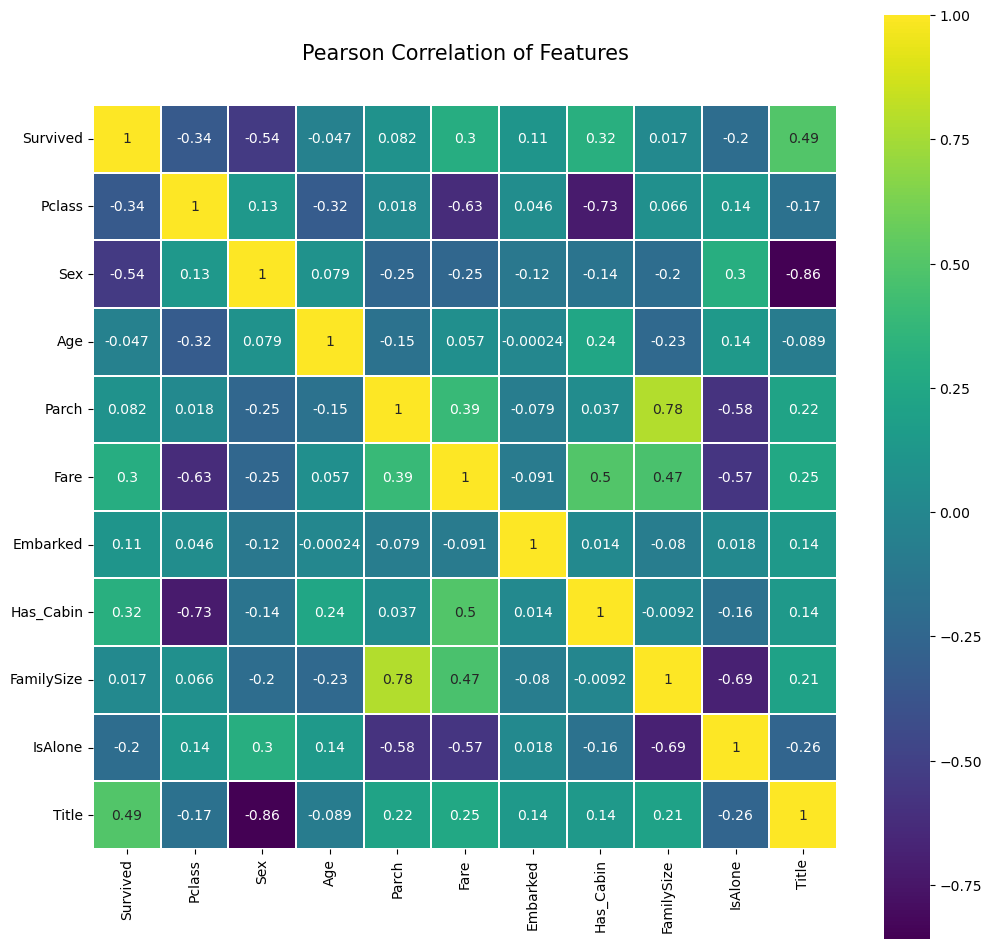

In [8]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
square=True, cmap=colormap, linecolor='white', annot=True)

Survived is high corr with Cabin, Title, Fare and negative corr with Sex and Pclass\

Sex has high negative corr with Title

Pclass have high negative corr with Has_Cabin  and Fare

###  3. Using the training set, determine the survival rate for each of the five different titles (Title feature)

In [24]:
titles = {
    1: "Mr",
    2: "Master",
    3: "Mrs",
    4: "Miss",
    5: "Other"
}

train['Title'] = train['Title'].map(titles)
surviced_rate = train.groupby('Title')['Survived'].mean()
surviced_rate

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Other     0.347826
Name: Survived, dtype: float64

### 4. Using the training set and cross-validation (10-fold), determine the best depth of the decision tree (the criterion for splitting gini, or entropy)

In [10]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

max_depth_range = np.arange(1, 10) 

clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)

scores_gini = []
for depth in max_depth_range:
    clf_gini.set_params(max_depth=depth)
    score = cross_val_score(clf_gini, X_train, y_train, cv=10, scoring='accuracy').mean()
    scores_gini.append(score)

clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

scores_entropy = []
for depth in max_depth_range:
    clf_entropy.set_params(max_depth=depth)
    score = cross_val_score(clf_entropy, X_train, y_train, cv=10, scoring='accuracy').mean()
    scores_entropy.append(score)

best_depth_gini = max_depth_range[np.argmax(scores_gini)]

best_depth_entropy = max_depth_range[np.argmax(scores_entropy)]

print(f"10 scores for gini classifier", scores_gini)
print(f"10 scores for entropy classifier", scores_entropy)

print(f"Best tree depth for Gini criterion: {best_depth_gini}")
print(f"Best tree depth for Entropy criterion: {best_depth_entropy}")

10 scores for gini classifier [0.7822846441947565, 0.7912983770287141, 0.8305243445692885, 0.8125468164794007, 0.8136953807740325, 0.8092759051186018, 0.8126092384519351, 0.8092759051186016, 0.8260923845193509]
10 scores for entropy classifier [0.7822846441947565, 0.7890511860174781, 0.8316479400749064, 0.8215355805243446, 0.8237952559300874, 0.818227215980025, 0.8081023720349563, 0.809250936329588, 0.8193258426966292]
Best tree depth for Gini criterion: 3
Best tree depth for Entropy criterion: 3


### 5,6,7,8 below

Build a decision tree using from the previously determined maximum depth (gini, or entropy split criterion)
 
Make predictions of survivability for passengers from the test set and record the results in a file
 
Visualize the decision tree

Examine how the following tree parameters affect the accuracy of classification: splitting criterion (gini vs. entropy), smallest number of

In [11]:
decision_tree_entropy = DecisionTreeClassifier(max_depth = 3,
criterion='entropy')
decision_tree_entropy.fit(X_train, y_train)
y_entropy_pred = decision_tree_entropy.predict(test)

In [12]:
decision_tree_gini = DecisionTreeClassifier(max_depth = 3,
criterion='gini')
decision_tree_gini.fit(X_train, y_train)
y_gini_pred = decision_tree_gini.predict(test)

In [13]:
np.savetxt('entropy_pred',y_entropy_pred)
np.savetxt('gini_pred',y_gini_pred)

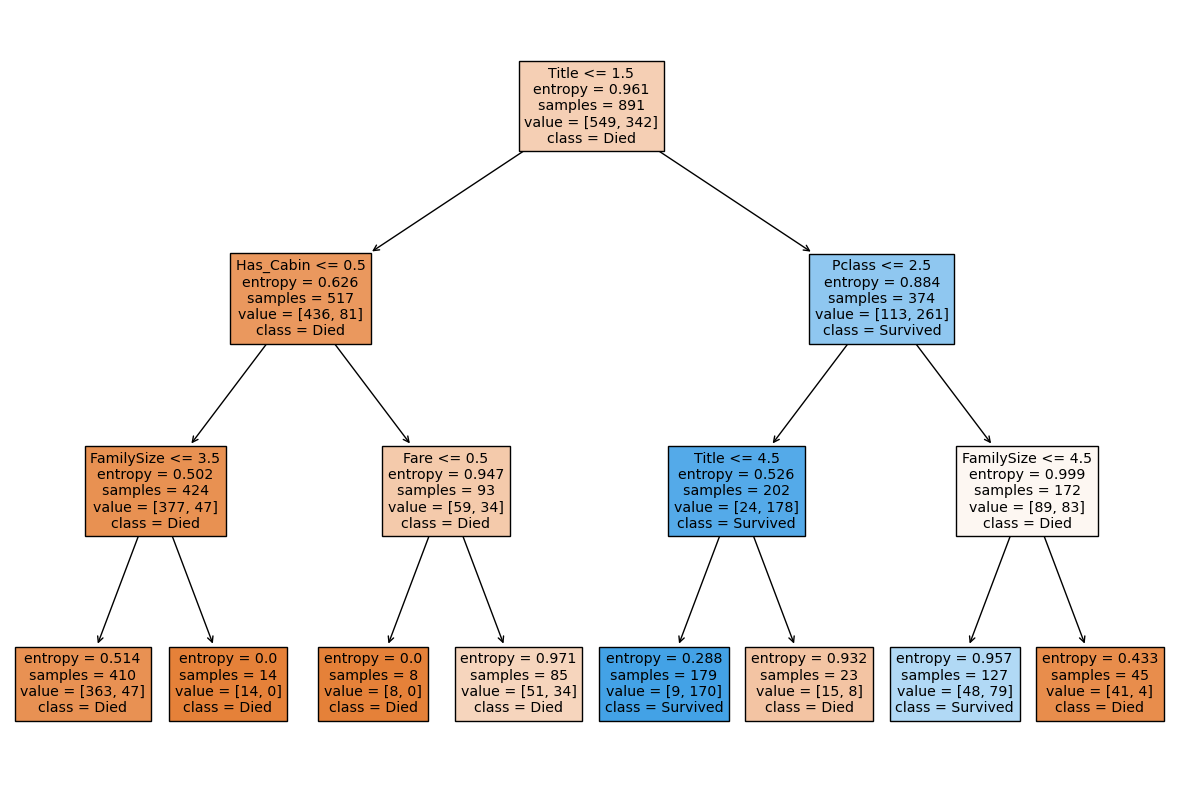

In [14]:
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_entropy, filled=True, feature_names=X_train.columns.tolist(), class_names=['Died', 'Survived'])
plt.show()

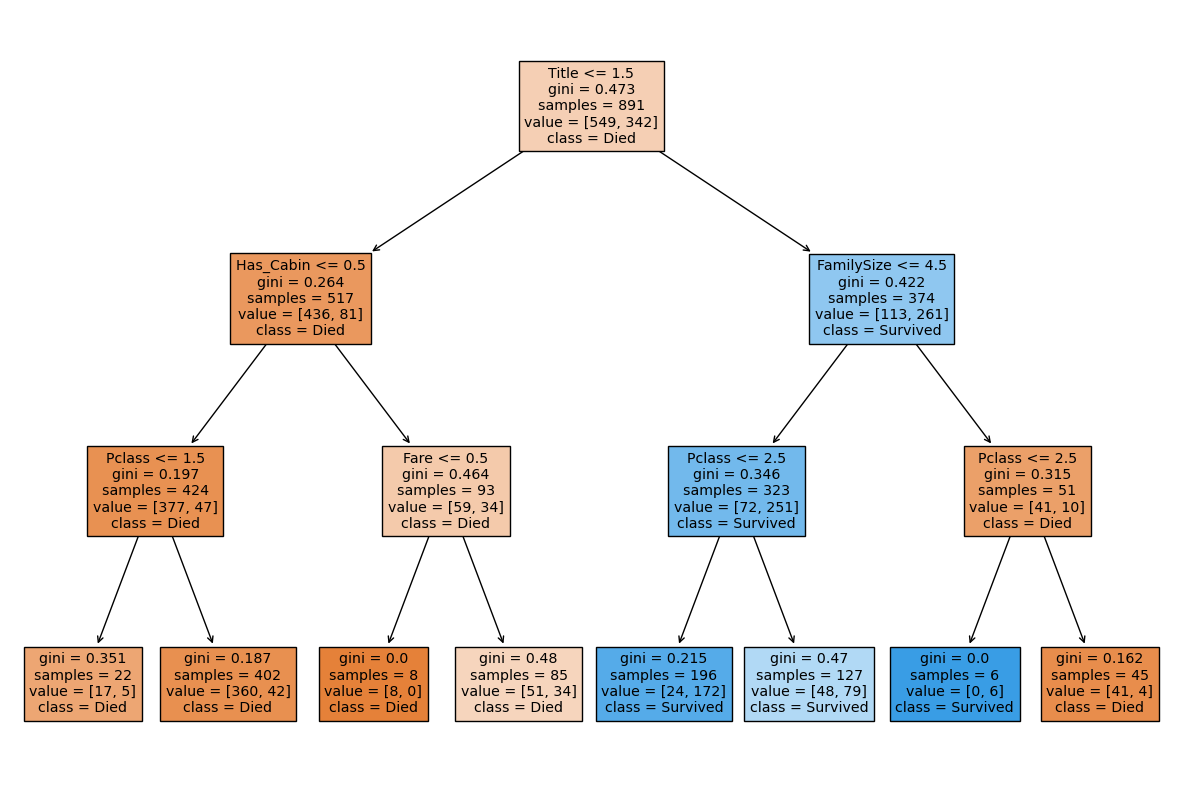

In [15]:
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_gini, filled=True, feature_names=X_train.columns.tolist(), class_names=['Died', 'Survived'])
plt.show()

### 8. Examinate how the following tree parameters affect the classification accuracy: the splitting criterion (gini vs. entropy), the smallest number of records in a leaf, and the maximum depth of the tree

In [18]:
# source https://medium.com/@ompramod9921/decision-trees-8e2391f93fa7#:~:text=max_depth%3A%20This%20parameter%20controls%20the,a%20maximum%20value%20for%20max_depth.

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3, 4, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Print all results
for params, mean_test_score, scores in zip(grid_search.cv_results_['params'],
                                           grid_search.cv_results_['mean_test_score'],
                                           grid_search.cv_results_['std_test_score']):
    print(f"Parameters: {params}, Mean Test Score: {mean_test_score}, Standard Deviation: {scores}")

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Best config and test accuracy:", grid_search.best_params_, accuracy)


Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}, Mean Test Score: 0.7919874312647289, Standard Deviation: 0.03243944353060948
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2}, Mean Test Score: 0.7949500617214679, Standard Deviation: 0.03334992599280401
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4}, Mean Test Score: 0.8024127482886321, Standard Deviation: 0.028070528868243818
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}, Mean Test Score: 0.7799910223319493, Standard Deviation: 0.046910839123935746
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}, Mean Test Score: 0.7799910223319493, Standard Deviation: 0.046910839123935746
Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}, Mean Test Score: 0.7799910223319493, Standard Deviation: 0.046910839123935746
Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}, Mean Te

### 9. Divide the training set (for which we have labels available) into a new training set (75%) and a new test set (25%)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### 10. Determine and visualize the confusion matrix

In [19]:
clf = SVC(random_state=42)
clf.fit(X_train, y_train)

SVC(random_state=42)

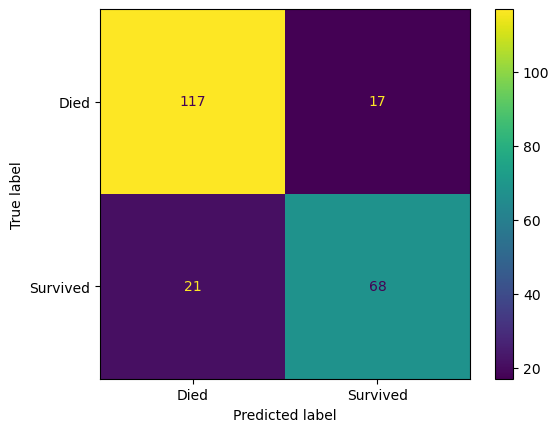

In [20]:
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test,display_labels=['Died', 'Survived'])

### 11. Determine measures of the constructed classifier

In [21]:
y_pred = clf.predict(X_test)

In [22]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [23]:
print("f1 score:", f1)
print("accuracy score:", accuracy)
print("average precision score:", average_precision)
print("recall score:", recall)

f1 score: 0.7816091954022989
accuracy score: 0.8295964125560538
average precision score: 0.7054063586436238
recall score: 0.7640449438202247
